# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [142]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [143]:
# Global constant
_lines = [] # motion tracker
TRACKER_SIZE = 2
SCREEN_WIDTH = 960
SCREEN_HIGHT = 540
SCREEN_HIGHT_OFFSET = 75
SLOPE_TOLERANCE_MIN = 0.3
SLOPE_TOLERANCE_MAX = 0.9

# motion tracker

_frame_count = 0

""" Global variables """
_prev_pos_m = None
_prev_pos_b = None
_prev_neg_m = None
_prev_neg_b = None

_prev_slope_diff = None
_prev_b_diff = None

_prev_pos_line = None
_prev_neg_line = None

def init_variables():
    global _prev_pos_m
    global _prev_neg_m
    global _prev_pos_b
    global _prev_neg_b
    global _lines
    global _frame_count
    
    global _prev_pos_line
    global _prev_neg_line
    
    _frame_count = 0
    _lines = []
    _prev_pos_m = None
    _prev_neg_m = None
    _prev_pos_b = None    
    _prev_neg_b = None    
    
    _prev_pos_line = None
    _prev_neg_line = None

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


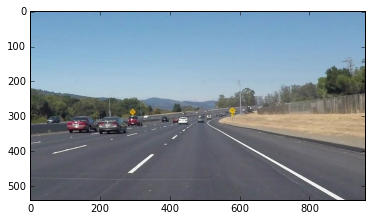

In [144]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [148]:
""" Helper Functions """
import math

#http://stackoverflow.com/questions/2824478/shortest-distance-between-two-line-segments
def segments_distance(x11, y11, x12, y12, x21, y21, x22, y22):
    """ distance between two segments in the plane:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
    """
    if segments_intersect(x11, y11, x12, y12, x21, y21, y22, y22): return 0
    # try each of the 4 vertices w/the other segment
    distances = []
    distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
    distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
    distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
    distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
    return min(distances)

def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
    """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
    """
    dx1 = x12 - x11
    dy1 = y12 - y11
    dx2 = x22 - x21
    dy2 = y22 - y21
    delta = dx2 * dy1 - dy2 * dx1
    if delta == 0: return False  # parallel segments
    s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
    t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
    return (0 <= s <= 1) and (0 <= t <= 1)

def point_segment_distance(px, py, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    if dx == dy == 0:  # the segment's just a point
        return math.hypot(px - x1, py - y1)

    # Calculate the t that minimizes the distance.
    t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

    # See if this represents one of the segment's
    # end points or a point in the middle.
    if t < 0:
        dx = px - x1
        dy = py - y1
    elif t > 1:
        dx = px - x2
        dy = py - y2
    else:
        near_x = x1 + t * dx
        near_y = y1 + t * dy
        dx = px - near_x
        dy = py - near_y

    return math.hypot(dx, dy)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [135]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

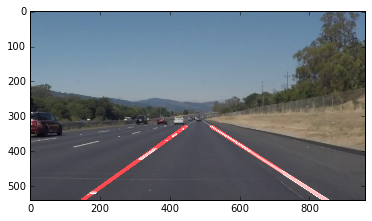

In [136]:
# Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def test_image_tmp(img):
    global _prev_pos_m
    global _prev_neg_m
    init_variables()
    #_prev_pos_m = 0.1
    print(_prev_neg_m, _prev_pos_m)
    masked_edges = masked_canny_edges(img, 5, 50, 150)

    plt.imshow(masked_edges)


    
def test_image(img):
    global _prev_pos_m
    global _prev_neg_m
    init_variables()
    #_prev_pos_m = 0.1
    print(_prev_neg_m, _prev_pos_m)
    masked_edges = masked_canny_edges(img, 5, 50, 150)

    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_length = 10
    max_line_gap = 1

    imshape = img.shape
    line_image = np.zeros((imshape[0], imshape[1])) # np.copy(img)*0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    left_x = []; left_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if  (x1 < 480 and x2 < 480):
                left_x.extend(np.linspace(x1, x2, endpoint=True).tolist())
                left_y.extend(np.linspace(y1, y2, endpoint=True).tolist())
                #print(x1, y1, x2, y2)
                #cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#    plt.plot(left_x, left_y, 'o')
#    print(len(left_x))
#    print(len(left_y))
    #[vx,vy,x,y] = cv2.fitLine(lines, cv2.DIST_L2,0,0.01,0.01)
    pos_m, pos_b = np.polyfit(left_x, left_y, 1)
    print(pos_m, pos_b)
#    print(line_image[1])
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

#    left_lane_line, right_lane_line = get_lanes(masked_edges, 10, 10, 1)

#    draw_line(left_lane_line, line_image)
#    draw_line(right_lane_line, line_image)

    #result = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    #result = cv2.addWeighted(img, 0.8, result, 1, 0)
    #plt.imshow(result)
    #print(lines)
    #plt.imshow(line_image)
    print(line_image.shape)
    print(line_image[0][1])    

sample_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#test_image(sample_image)
test1 = process_image(sample_image)
plt.imshow(test1)

In [149]:
def masked_image(img):
    
    mask = np.zeros_like(img)   
    ignore_mask_color = 255       
    imshape = img.shape
    exclusion_y_offset = SCREEN_HIGHT_OFFSET        
    x_offset = 200
    exclusion_x_offset = 40

    y_height = imshape[0]*0.60 + SCREEN_HIGHT_OFFSET
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2 - x_offset, y_height), (imshape[1]/2 + x_offset, y_height), \
                            (imshape[1],imshape[0]), \
                            (imshape[1]*0.70,imshape[0]), (imshape[1]*0.5 + exclusion_x_offset, y_height + exclusion_y_offset), (imshape[1]*0.5 - exclusion_x_offset, y_height + exclusion_y_offset), \
                            (imshape[1]*0.30,imshape[0]), (0,imshape[0])
    ]], dtype=np.int32)       
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return cv2.bitwise_and(img, mask)
    
    

def masked_canny_edges(img, kernel_size, low_threshold, high_threshhold):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    canny_edges = cv2.Canny(blur_gray, low_threshold, high_threshhold)
    masked_edges = masked_image(canny_edges)

    return masked_edges       

def preprocess(lines, neg_m, neg_b, pos_m, pos_b):
    """ Pre-process input data """
    result_left = False
    result_right = False

    if _prev_pos_line != None:
        pos_p1 =([_prev_pos_line[0], _prev_pos_line[1]])
        pos_p2 = ([_prev_pos_line[2], _prev_pos_line[3]])
    if _prev_neg_line != None:        
        neg_p1 = ([_prev_neg_line[0], _prev_neg_line[1]])
        neg_p2 = ([_prev_neg_line[2], _prev_neg_line[3]])
        
    for line in lines:
        for x1,y1,x2,y2 in line:

            p3 = ([x1, y1])
            p4 = ([x2, y2])
            
            
            drop_count = 0

            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1
            height_unit = 1
            height = abs(y2 - y1)
            if abs(m) < SLOPE_TOLERANCE_MIN or abs(m) > SLOPE_TOLERANCE_MAX:
                #print('Drop samples due to slope out of range', m)
                drop_count = drop_count + 1
                continue

            hrange = height//height_unit
            if hrange < 1:
                continue
            if  (x1 < SCREEN_WIDTH/2 and x2 < SCREEN_WIDTH/2): # Left side
                if m > 0:
                    continue
                if _prev_neg_line != None:
                    distance = segments_distance(neg_p1[0], neg_p1[1], neg_p2[0], neg_p2[1], p3[0], p3[1], p4[0], p4[1])
                    if distance > 4.0:
                        continue

                for i in range(hrange):
                    result_left = True                    
                    neg_m.append(m)
                    neg_b.append(b)
                    
            else: # Right side
                if m < 0:
                    continue                
                if _prev_pos_line != None:
                    distance = segments_distance(pos_p1[0], pos_p1[1], pos_p2[0], pos_p2[1], p3[0], p3[1], p4[0], p4[1])
                    if distance > 4.0:
                        continue
                
                for i in range(hrange):
                    result_right = True                    
                    pos_m.append(m)
                    pos_b.append(b)

    return result_left and result_right  


def get_lane_markings(frame_img):
    """ Detect the lane markings """
    # Convert BGR to HSV
    kernel_size = 5
    guassian_blur = cv2.GaussianBlur(frame_img, (kernel_size, kernel_size), 0)
    hsv = cv2.cvtColor(guassian_blur, cv2.COLOR_BGR2HSV)
    
    # define range of blue color in HSV
    lower_white = np.array([60,0,0])
    upper_white = np.array([100,100,255])

    lower_yellow = np.array([80,100,100])
    upper_yellow = np.array([120,255,255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white) # I have the Green threshold image.

    # Threshold the HSV image to get only blue colors
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    mask = white_mask + yellow_mask

    # Bitwise-AND mask and original image
    temp = cv2.bitwise_and(frame_img, frame_img, mask= mask)   
    #kernel = np.ones((5,5),np.uint8)

    #dilation = cv2.dilate(temp,kernel,iterations = 1)
    return temp

    
def get_lanes(mask_img, rho, theta, threshold, min_line_length, max_line_gap):
    global _prev_pos_m
    global _prev_neg_m
    global _prev_pos_b
    global _prev_neg_b
    global _prev_slope_diff
    global _prev_b_diff
    global _prev_pos_line
    global _prev_neg_line
    
    line_length = min_line_length

    while(True):    
        lines = cv2.HoughLinesP(mask_img, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)
        if len(lines) <= 1 and line_length > 5:
            line_length -= 5
            print('hough min length not worked. Try again with {0}'.format(line_length))            
        else:
            break               
    

    neg_m_arr = []; neg_b_arr = []; pos_m_arr = []; pos_b_arr = []

    """ Step1: Pre-process data """

    """ Step1.1: Get current slope """
    is_data_clean = preprocess(lines, neg_m_arr, neg_b_arr, pos_m_arr, pos_b_arr)    

    for tracker_lines in _lines:
        preprocess(tracker_lines, neg_m_arr, neg_b_arr, pos_m_arr, pos_b_arr)

    neg_m = np.mean(neg_m_arr)
    neg_b = np.mean(neg_b_arr)
    pos_m = np.mean(pos_m_arr)
    pos_b = np.mean(pos_b_arr)
        
    slope_diff = neg_m**2 + pos_m**2
    b_diff = pos_b + neg_b
    
    if is_data_clean:
        _lines.insert(0, lines)
    else:
        print('Data not clean!!!')
    
    """ Step2: Dampen the change of slop """
    if _prev_neg_m != None:
        damping_rate = 0.2
        neg_m = neg_m * damping_rate + _prev_neg_m * (1 - damping_rate)
        neg_b = neg_b * damping_rate + _prev_neg_b * (1 - damping_rate)
        pos_m = pos_m * damping_rate + _prev_pos_m * (1 - damping_rate)
        pos_b = pos_b * damping_rate + _prev_pos_b * (1 - damping_rate)    

    y_cut = SCREEN_HIGHT * 0.6 + SCREEN_HIGHT_OFFSET
    y_bottom = SCREEN_HIGHT

    pos_y1 = y_cut
    pos_x1 = (pos_y1 - pos_b) / pos_m
    pos_y2 = y_bottom    
    pos_x2 = (pos_y2 - pos_b) / pos_m
    
    neg_y1  = y_cut
    neg_x1 = (neg_y1 - neg_b) / neg_m
    neg_y2 = y_bottom
    neg_x2 = (neg_y2 - neg_b) / neg_m
    
    pos_line = np.array([neg_x1, neg_y1, neg_x2, neg_y2]).astype(int)
    neg_line = np.array([pos_x1, pos_y1, pos_x2, pos_y2]).astype(int)
    
    if (is_data_clean and len(_lines) > TRACKER_SIZE):
        #print('Dropping the oldest')
        _lines.pop()
        
    _prev_neg_m = neg_m
    _prev_neg_b = neg_b
    _prev_pos_m = pos_m
    _prev_pos_b = pos_b
    _prev_slope_diff = slope_diff
    _prev_b_diff = b_diff
    
    _prev_pos_line = neg_line
    _prev_neg_line = pos_line 
    
    return pos_line, neg_line, lines

def draw_line(line, line_image):
    x1 = line[0]; y1 = line[1]; x2 = line[2]; y2 = line[3];    
    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)       


In [150]:
from moviepy.editor import VideoFileClip

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [151]:
def debug_image(lane_marking_img, frame_img, hough_lines, line_image, masked_edges):
#    global _frame_count
#    _frame_count += 1    
#    mpimg.imsave('yellow/' + str(_frame_count).zfill(3) + '.jpg', frame_img)    
    for line in hough_lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1) 
            if abs(m) < SLOPE_TOLERANCE_MIN or abs(m) > SLOPE_TOLERANCE_MAX:
                #print('Dropping...')
                cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),4) 
            else:
                #print('Slope... m:', m)                
                cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),4) 

    #Create a "color" binary image to combine with line image
    color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

    #Draw the lines on the edge image
    result = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    #result = cv2.addWeighted(frame_img, 0.8, temp, 1, 0) 
    return result

def process_image(frame_img, debug=False):

    # NOTE: The output you return should be a color image (3 channel) for processing video below
    line_image = np.copy(frame_img)*0

    """ Step1: Get lane markings """
    lane_markings = get_lane_markings(frame_img)
    
    """ Step2: Get masked hough lines """    
    enhanced_image = cv2.add(lane_markings,frame_img)    
    masked_edges = masked_canny_edges(enhanced_image, 5, 50, 150)

    left_lane_line, right_lane_line, hough_lines = get_lanes(masked_edges, 1, np.pi/180, 10, 10, 1)
    
    """ Step3: Draw lanes """
    draw_line(left_lane_line, line_image)
    draw_line(right_lane_line, line_image)
 
    if debug:
        debug_result = debug_image(lane_markings, frame_img, hough_lines, line_image, masked_edges)
        result = cv2.addWeighted(frame_img, 0.8, debug_result, 1, 0) 
        return result
    else:
        # Draw the lines on the edge image
        result = cv2.addWeighted(frame_img, 0.8, line_image, 1, 0)
        return result

Let's try the one with the solid white lane on the right first ...

In [159]:
SCREEN_WIDTH = 960
SCREEN_HIGHT = 540
SCREEN_HIGHT_OFFSET = 60

init_variables()

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
init_variables()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  2%|▏         | 5/222 [00:00<00:04, 46.46it/s]

Data not clean!!!


 23%|██▎       | 52/222 [00:00<00:03, 53.38it/s]

Data not clean!!!


 65%|██████▍   | 144/222 [00:02<00:01, 51.98it/s]

Data not clean!!!


 70%|███████   | 156/222 [00:03<00:01, 51.17it/s]

Data not clean!!!


 82%|████████▏ | 182/222 [00:03<00:00, 47.29it/s]

Data not clean!!!


 87%|████████▋ | 193/222 [00:03<00:00, 49.04it/s]

Data not clean!!!


 92%|█████████▏| 205/222 [00:04<00:00, 50.02it/s]

Data not clean!!!


 98%|█████████▊| 217/222 [00:04<00:00, 50.63it/s]

Data not clean!!!


100%|█████████▉| 221/222 [00:04<00:00, 50.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 4.8 s, sys: 607 ms, total: 5.41 s
Wall time: 4.85 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [160]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [157]:
SCREEN_WIDTH = 960
SCREEN_HIGHT = 540
SCREEN_HIGHT_OFFSET = 60    

init_variables()    

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


 10%|▉         | 65/682 [00:01<00:10, 57.51it/s]

Data not clean!!!


 11%|█▏        | 77/682 [00:01<00:11, 54.74it/s]

Data not clean!!!


 21%|██        | 143/682 [00:02<00:09, 55.92it/s]

Data not clean!!!


 37%|███▋      | 251/682 [00:04<00:08, 52.22it/s]

Data not clean!!!


 39%|███▊      | 263/682 [00:04<00:08, 51.52it/s]

Data not clean!!!


 66%|██████▌   | 447/682 [00:08<00:04, 47.43it/s]

Data not clean!!!


100%|█████████▉| 681/682 [00:13<00:00, 50.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.2 s, sys: 684 ms, total: 16.9 s
Wall time: 14 s


In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### How to make the algorithm better / more robust?
- To make the lane findings algorithm better/robust, I willl need to use the perspective transformation so that I can work on a rectangular space instead of a triange with vanishing point.
- I will need to enhance the algorithms so that it is not limited to two lanes but multiple lanes.
- Instead of purely relying on the Canny edge algorithm, the algorithm can be further enhanced by applying color thresholds to be more robust when the frame is impacted by shadow.

### Where will my current algorithm be likely to fail?
- My algorithm cannot handle curved lines
- My algorithm will most likely fail when it fails to detect edges due to shadow or too much light.
- My algorithm will also likely fail in bad weather such as rain or snow.
- My algorithm will also probably fail when a truck is blocking the front view.

### Other thoughts
- There are too many failure scenarios to consider when detecting the lanes. It may make sense to use deep learning to train how to steer handle rather than programming for every plausible scenarios.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [156]:
SCREEN_WIDTH = 1280
SCREEN_HIGHT = 720
SCREEN_HIGHT_OFFSET = 30    

init_variables()    

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


 41%|████      | 103/251 [00:03<00:05, 26.21it/s]

Data not clean!!!


 63%|██████▎   | 157/251 [00:06<00:04, 23.32it/s]

Data not clean!!!


100%|██████████| 251/251 [00:10<00:00, 24.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.2 s, sys: 1.5 s, total: 12.7 s
Wall time: 11.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))